In [7]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *
DATA_DIR = '/work/users/k/4/k4thryn/Repos/OLD_EpSampling_Nov2024/data/'

pd.set_option('display.max_columns', None)

### Functions

In [8]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.model_selection import train_test_split

def get_model_df(df, X_COLS, Y_COL, NAIVE_COL):
    cols = ['Date', 'Fips'] + X_COLS + [Y_COL, NAIVE_COL]
    df = df[cols]    
    return df

def get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG):    
    X_train = df_train[X_COLS]
    y_train = df_train[Y_COL]
    X_test = df_test[X_COLS]
    
    df_pred = df_test.copy()
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    df_pred['Algorithm'] = ALG
    df_pred[PRED_COL] = reg.predict(X_test)
    
    return df_pred

# <font color=blue> 1) Dataset

In [9]:
ts = '20241108-123515'
fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
dff = pd.read_csv(fpath)

pd.set_option('display.max_columns', None)

fpath = os.path.join(DATA_DIR,f'fips-by-state.csv')
df_fips = pd.read_csv(fpath,encoding = 'ISO-8859-1')
df_fips.rename({'01001':'Fips','Autauga County': 'County','AL': 'State'},axis=1,inplace=True)
df_fips.set_index('Fips',inplace=True)

pd.set_option('display.max_columns', None)

df = pd.merge(dff, df_fips, on='Fips')
df = df[['Date','County','Fips','Proj_state_inc_deaths',
         'True_county_inc_deaths','Pop','Naive_proj_deaths']]

df['County'] = df.County.apply(lambda x: x[:x.index(' ')])  
df_temp = df.copy()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

dff = df[df.Date.isin([20220205, 20220212, 20220219])]
dff = dff[(dff['Pop'] < 3600.5) 
         | (dff['Pop'] > 1000000) | (dff['County'] == 'Orange')
        | (dff['County'] == 'Wake')]



dfff = dff[['Date','County','Pop','Proj_state_inc_deaths',
           'True_county_inc_deaths','Naive_proj_deaths']]

d = {'Proj_state_inc_deaths':'PROJ state deaths',
     'True_county_inc_deaths':'TRUE county deaths',
     'Pop':'County population',
     'Naive_proj_deaths':'Naive PROJ county deaths',
    }

d = {'Proj_state_inc_deaths':'PROJ state',
     'True_county_inc_deaths':'TRUE count',
     'Pop':'County pop',
     'Naive_proj_deaths':'Naive PROJ ',
    }

dfff.rename(d,axis=1,inplace=True)


dts = [str(x) for x in dfff.Date.values]
new_dts = []
for x in dts:
    dt = '-'.join([x[:4], x[4:6], x[6:]])
    new_dts.append(dt)
    
dfff['Date'] = new_dts
# diplay(dfff)





# from textwrap import wrap
# cols = {k: '\n'.join(wrap(v,10)) for k,v in df.columns}
# cols
# # import textwrap

# # cols = ['Very Long Column Title ' + str(i) for i in range(2)]

# # Split wide columns, you can then join these with any delimiter you'd like
# # cols = [textwrap.wrap(x, width=20) for x in dfff.columns]
# # print(cols)
# # dfff.columns = cols


dfff.sort_values('Date',inplace=True)
dfff = dfff.reset_index(drop=True)
with pd.option_context('display.precision', 3):
    dfff.style.set_table_styles([dict(selector="th",props=[('max-width', '1px')])])
    display(dfff)

,Date,County,County pop,PROJ state,TRUE count,Naive PROJ
0,2022-02-05,Mecklenburg,1100984,430.0,37.0,45.666
1,2022-02-05,Orange,147376,430.0,0.0,6.113
2,2022-02-05,Tyrrell,3436,430.0,0.0,0.143
3,2022-02-05,Wake,1112883,430.0,2.0,46.160
4,2022-02-12,Mecklenburg,1100984,453.0,31.0,48.109
5,2022-02-12,Orange,147376,453.0,1.0,6.440
6,2022-02-12,Tyrrell,3436,453.0,0.0,0.150
7,2022-02-12,Wake,1112883,453.0,12.0,48.629
8,2022-02-19,Mecklenburg,1100984,561.0,23.0,59.579
9,2022-02-19,Orange,147376,561.0,0.0,7.975


In [10]:
Y_COL = 'True_county_inc_deaths'
X_COLS = ['Proj_state_inc_deaths', 'Pop']
NAIVE_COL = 'Naive_proj_deaths'

df_temp.dropna(inplace=True)
df_temp = df_temp[df_temp[Y_COL] >= 0]

df = get_model_df(df_temp, X_COLS, Y_COL, NAIVE_COL)
display(df)

,Date,Fips,Proj_state_inc_deaths,Pop,True_county_inc_deaths,Naive_proj_deaths
0,20200620,37001,122.952380,169185,3.0,2.006526
1,20200627,37001,100.308655,169185,1.0,1.636991
2,20200704,37001,119.399124,169185,1.0,1.948538
3,20200711,37001,100.119064,169185,0.0,1.633897
4,20200718,37001,120.176330,169185,2.0,1.961222
...,...,...,...,...,...,...
9895,20220409,37199,55.000000,18357,0.0,0.097389
9896,20220416,37199,41.000000,18357,0.0,0.072599
9897,20220423,37199,60.000000,18357,0.0,0.106243
9898,20220430,37199,33.000000,18357,0.0,0.058433


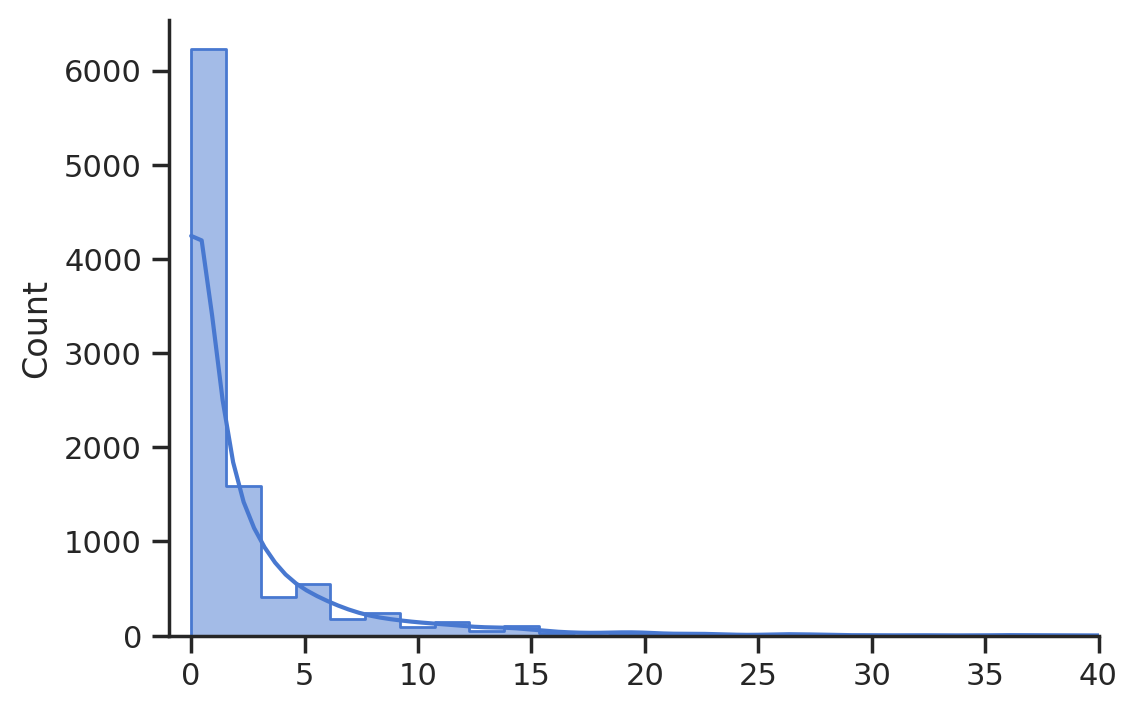

Are all targets non-negative? True


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='muted') 
DPI = 200
FIGSIZE = (6,4)

plt.figure(figsize=FIGSIZE)
sns.histplot(df[Y_COL].values, bins=60, kde=True, element='step')
sns.despine()
plt.xlim((-1, 40))
plt.gcf().set_dpi(DPI)
plt.show()

print(f"Are all targets non-negative? {(df[Y_COL].min() >= 0)}")

## <font color=blue> 2) Training: County population + Predicted state deaths

    
<font color=blue> _Compare regression algorithms:_
1. <font color=blue>  Linear 
1. <font color=blue>  Poisson 
1. <font color=blue>  Zero-inflated
    
This is our most simplistic model. We are predicting the number of county deaths given two covariates: 1) projected state deaths (from COVIDHub) and 2) county population. We will consider vanilla linear regression, poisson regression, and zero-inflated regression.

### <font color=blue> Model design
- <font color=blue> **_Train-test split:_** Our training and test/evaluation set will be partitioned based on (2 month)-wise chunks. That is, we will evaluate our model on temporally consecutive targets over the course of 8 weeks, and we will train on the remaining weeks.
    - <font color=black> **Train samps:** 7939
    - <font color=black> **Test samps:** 771
- <font color=blue> **_Cross validation protocol:_** We will train a model for each month, for a total of 10 models. From these, we can evaluate average performance for each regression algorithm.
    

In [12]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklego.meta import ZeroInflatedRegressor as zir_model
from sklearn.svm import SVC

def get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG):    
    X_train = df_train[X_COLS]
    y_train = df_train[Y_COL]
    X_test = df_test[X_COLS]
    
    df_pred = df_test.copy()
    
    if ALG=='Linear':
        reg = linear_model.LinearRegression().fit(X_train, y_train)
    elif ALG=='Poisson':
        reg = linear_model.PoissonRegressor().fit(X_train, y_train)
    elif ALG=='Zero-Inflated':
        reg = zir_model(
            classifier=SVC(),
            regressor=linear_model.LinearRegression()).fit(X_train, y_train) 
            
    df_pred['Algorithm'] = ALG
    df_pred[PRED_COL] = reg.predict(X_test)
    
    return df_pred


# ALG = 'Linear Regression'

res_dfs = []
models = {}
chunks = get_chunks(list(df.Date.unique()), num_membs=8)

for ALG in ['Linear','Poisson','Zero-Inflated']:
    for i,test_chunk in tqdm(enumerate(chunks), total=len(chunks)):

        df_train, df_test = get_date_chunked_splits(df, chunks, i)
        
        # # # # # # # # # # # # # # # #
        df_test = df_train.copy()
        # # # # # # # # # # # # # # # #
        
        df_test[f'Run'] = i
        
        PRED_COL = 'PRED county deaths'    
        df_res = get_df_res(df_train, df_test, X_COLS, Y_COL, PRED_COL, ALG)

#         if i==0: display(df_test.head(), df_res.head())

        res_dfs.append(df_res)
    
df_full_res = pd.concat(res_dfs)
display(df_full_res)

100%|██████████| 13/13 [01:32<00:00,  7.11s/it]


,Date,Fips,Proj_state_inc_deaths,Pop,True_county_inc_deaths,Naive_proj_deaths,Run,Algorithm,PRED county deaths
8,20200815,37001,208.0,169185,1.0,3.394464,0,Linear,3.164220
9,20200822,37001,149.0,169185,2.0,2.431611,0,Linear,2.657814
10,20200829,37001,165.0,169185,2.0,2.692724,0,Linear,2.795145
11,20200905,37001,157.0,169185,0.0,2.562167,0,Linear,2.726479
12,20200912,37001,176.0,169185,2.0,2.872239,0,Linear,2.889559
...,...,...,...,...,...,...,...,...,...
9893,20220326,37199,127.0,18357,0.0,0.224880,12,Zero-Inflated,0.000000
9894,20220402,37199,115.0,18357,0.0,0.203632,12,Zero-Inflated,0.000000
9895,20220409,37199,55.0,18357,0.0,0.097389,12,Zero-Inflated,0.000000
9896,20220416,37199,41.0,18357,0.0,0.072599,12,Zero-Inflated,0.000000


## <font color=blue> 3) Evaluation

## <font color=blue> a. _Metrics_ 
Average across cross-validation splits.

In [13]:
## GET PERFORMANCE !
# from epsampling.modeling import get_metrics_ser

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

def get_metrics_ser(df, target_col, pred_col, alg_col, naive_col):
    
    metrics_dict = {'MAE': mean_absolute_error,
                    'MedAE': median_absolute_error,
                    'MSE': mean_squared_error,
                    'RMSE': mean_squared_error,
                    'r2': r2_score
                    }
    
    mae = mean_absolute_error(df[target_col], df[pred_col])
    medae = median_absolute_error(df[target_col], df[pred_col])
    r2 = r2_score(df[target_col], df[pred_col])
    mse = mean_squared_error(df[target_col], df[pred_col])
    
    relmae = mae / mean_absolute_error(df[target_col],df[naive_col])
    
    ser = {'Algorithm':alg_col, 'MAE':mae, 'MedAE':medae, 
           'R-squared':r2, 'MSE': mse, 'relMAE': relmae,}
    
    return ser
    

metric_sers = []

for alg in df_full_res.Algorithm.unique():
#     print(alg)
    for run in df_full_res.Run.unique():

        subdf = df_full_res[(df_full_res['Run']==run) & (df_full_res['Algorithm']==alg)]
#         displa
        ser = get_metrics_ser(subdf, 
                              target_col=Y_COL,
                              pred_col=PRED_COL,
                              alg_col=alg,
                              naive_col=NAIVE_COL)

        metric_sers.append(ser)
    
df_run = pd.DataFrame(metric_sers)
# df_run

In [17]:
df_run

,Algorithm,MAE,MedAE,R-squared,MSE,relMAE
0,Linear,2.224511,1.277846,2.925739e-01,16.911814,1.098933
1,Linear,2.189286,1.221862,2.993398e-01,16.799874,1.102223
2,Linear,2.160781,1.187430,3.113091e-01,16.521760,1.107348
3,Linear,2.022282,1.125009,2.852005e-01,14.859272,1.088398
4,Linear,2.045604,1.139477,2.821076e-01,14.902252,1.096685
5,Linear,2.198010,1.259959,3.051659e-01,16.081677,1.099037
6,Linear,2.210163,1.258645,3.096039e-01,16.690314,1.088875
7,Linear,2.160698,1.200831,3.012347e-01,16.508790,1.092631
8,Linear,2.040485,1.113143,3.059631e-01,14.685925,1.108379
9,Linear,2.194927,1.240572,3.079567e-01,16.767749,1.101524


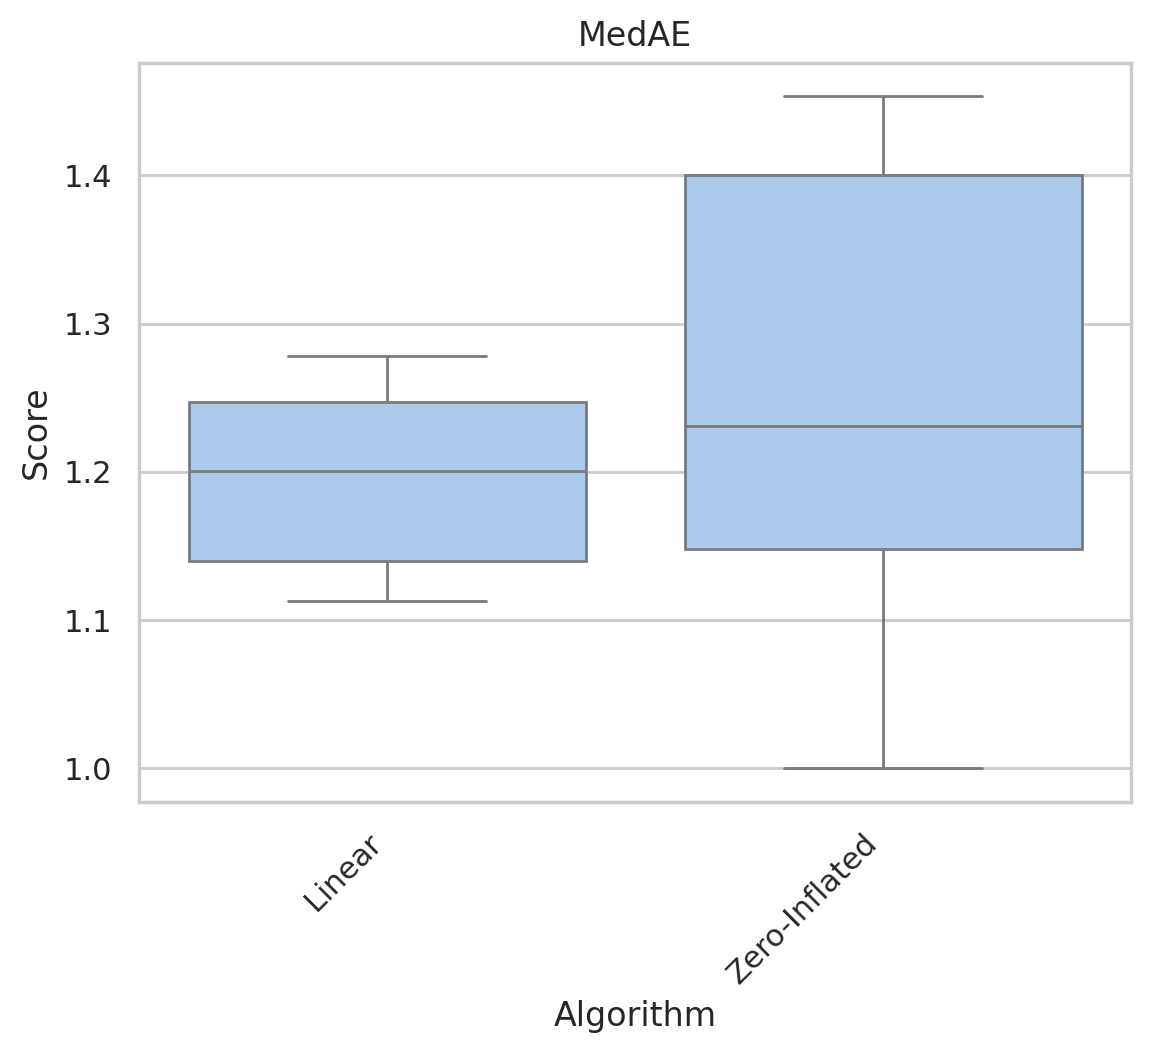

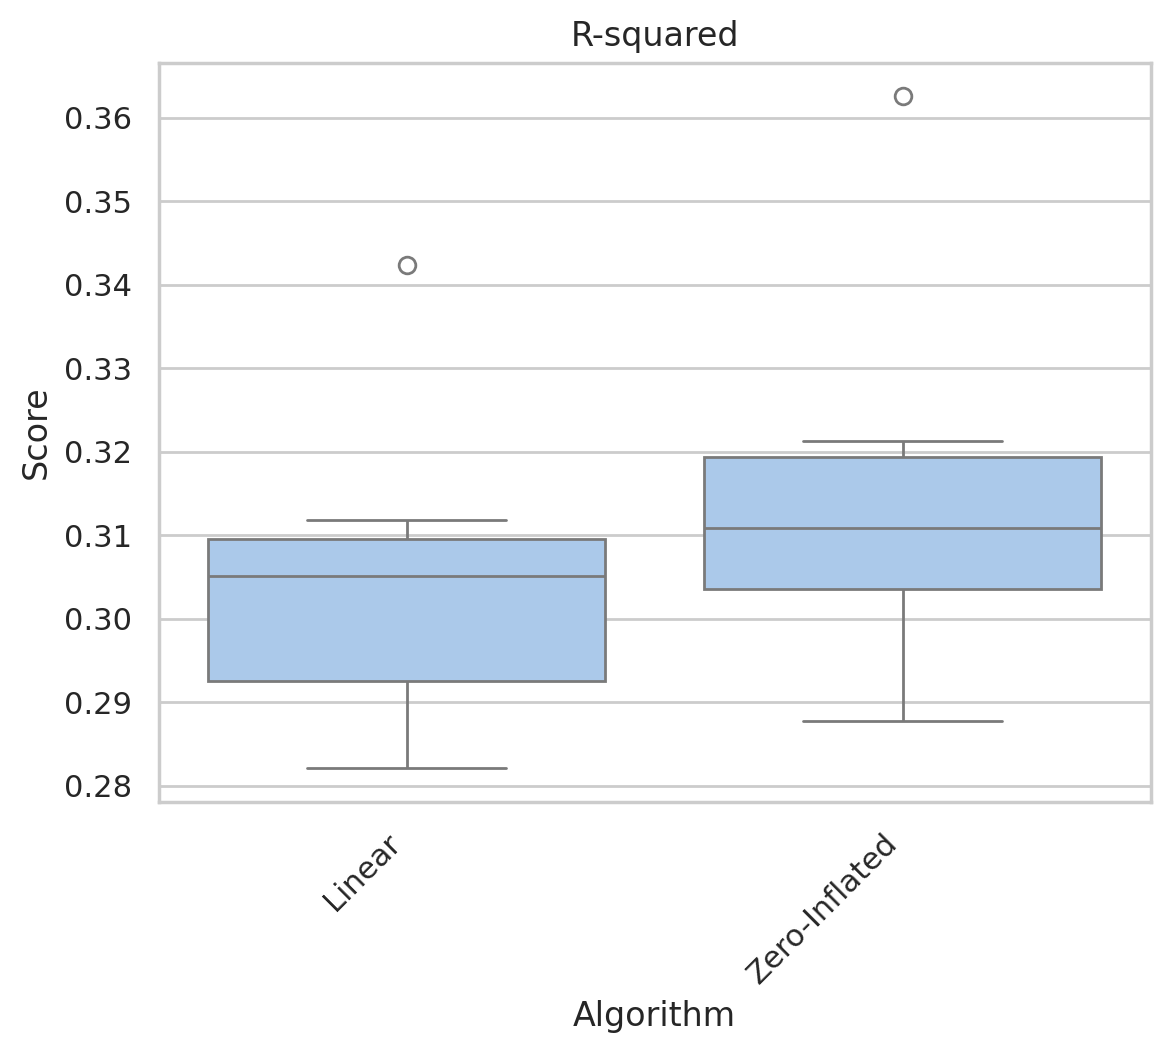

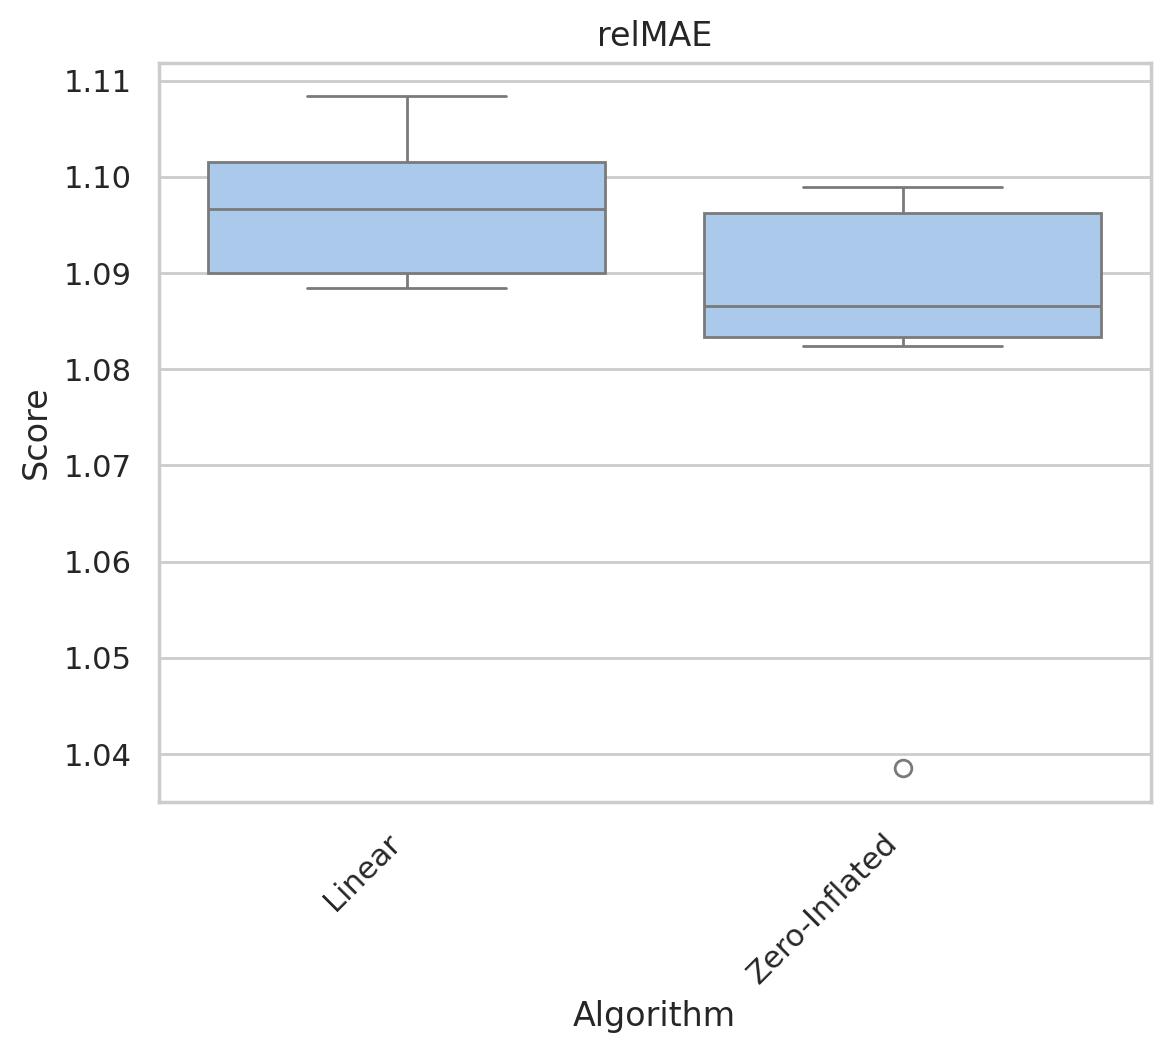


* MedAE *
== Linear ==
 Mean: 1.196
 Median: 1.201
== Zero-inflated ==
 Mean: nan
 Median: nan

* R-squared *
== Linear ==
 Mean: 0.303
 Median: 0.305
== Zero-inflated ==
 Mean: nan
 Median: nan

* relMAE *
== Linear ==
 Mean: 1.097
 Median: 1.097
== Zero-inflated ==
 Mean: nan
 Median: nan


In [33]:
df_melt = pd.melt(df_run, id_vars=['Algorithm'], 
                  value_vars=['MAE', 'MedAE', 'R-squared','MSE','relMAE'], 
                  var_name='Metric', value_name='Score')

df_melt = df_melt[df_melt.Algorithm!='Poisson']

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='whitegrid', palette='pastel') 
DPI = 200

for metric in  ['MedAE', 'R-squared', 'relMAE']:
    df_plot = df_melt[df_melt.Metric==metric]
#     display(df_plot)
    sns.boxplot(df_plot, x='Algorithm',y='Score')   
#     plt.figure(figsize=(5,8))
    plt.title(f'{metric}')
    plt.xticks(rotation=45,ha='right')
    plt.gcf().set_dpi(DPI)
    plt.show()

df_full_res

for metric in  ['MedAE', 'R-squared', 'relMAE']:
    print(f'\n* {metric} *')
    for alg in ['Linear','Zero-inflated']:
        dff_melt = df_melt[(df_melt['Metric']==metric) & (df_melt['Algorithm']==alg)]
        print(f'== {alg} ==')
        print(f' Mean: {round(dff_melt.Score.mean(),3)}\n Median: {round(dff_melt.Score.median(),3)}')
#         display(dff_melt)

In [29]:
df_melt

,Algorithm,Metric,Score
0,Linear,MAE,2.224511e+00
1,Linear,MAE,2.189286e+00
2,Linear,MAE,2.160781e+00
3,Linear,MAE,2.022282e+00
4,Linear,MAE,2.045604e+00
5,Linear,MAE,2.198010e+00
6,Linear,MAE,2.210163e+00
7,Linear,MAE,2.160698e+00
8,Linear,MAE,2.040485e+00
9,Linear,MAE,2.194927e+00


## <font color=blue> b. _Plots_

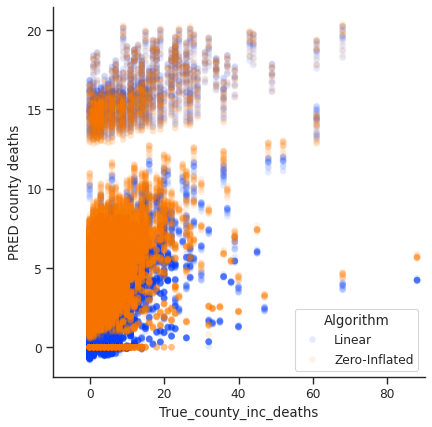

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='bright') 

figsize = (8,6)
alpha = 0.1
sizes = 2
linewidth = 0

DPI = 80
FIGSIZE = (6,6)

# df = df_pred

plt.figure(figsize=FIGSIZE)

# dfff = df_full_res[df_full_res['Algorithm']=='Zero-inflated']


this = df_full_res[df_full_res.Algorithm!='Poisson']

sns.scatterplot(data=this, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth, hue='Algorithm')
# sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth)
# sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth)

sns.despine()
plt.xlim((-10, 90))
plt.gcf().set_dpi(DPI)
plt.show()


# figsize = (8,6)
# alpha = 0.15
# sizes = 2
# linewidth = 0

# sns.regplot(data=df_full_res,  x=Y_COL, y=PRED_COL,
#             scatter_kws={'s':10, 'alpha':0.5}, line_kws={'color':'k','linewidth':1})
# sns.despine()
# plt.title('raw') 
# plt.title('y+(1)/pop*100000\n r2: 0.934336') 
# plt.title('y/pop*100000\n r2: -0.016382') 

# plt.show()

In [21]:
df_full_res

,Date,Fips,Proj_state_inc_deaths,Pop,True_county_inc_deaths,Naive_proj_deaths,Run,Algorithm,PRED county deaths
8,20200815,37001,208.0,169185,1.0,3.394464,0,Linear,3.164220
9,20200822,37001,149.0,169185,2.0,2.431611,0,Linear,2.657814
10,20200829,37001,165.0,169185,2.0,2.692724,0,Linear,2.795145
11,20200905,37001,157.0,169185,0.0,2.562167,0,Linear,2.726479
12,20200912,37001,176.0,169185,2.0,2.872239,0,Linear,2.889559
...,...,...,...,...,...,...,...,...,...
9893,20220326,37199,127.0,18357,0.0,0.224880,12,Zero-Inflated,0.000000
9894,20220402,37199,115.0,18357,0.0,0.203632,12,Zero-Inflated,0.000000
9895,20220409,37199,55.0,18357,0.0,0.097389,12,Zero-Inflated,0.000000
9896,20220416,37199,41.0,18357,0.0,0.072599,12,Zero-Inflated,0.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='bright') 

figsize = (8,6)
alpha = 0.1
sizes = 2
linewidth = 0

DPI = 80
FIGSIZE = (6,6)

# df = df_pred

plt.figure(figsize=FIGSIZE)

sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth, hue='Algorithm')
# sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth)
# sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth)

sns.despine()
plt.xlim((-10, 90))
plt.gcf().set_dpi(DPI)
plt.show()


# figsize = (8,6)

### <font color=blue> Performance across counties (by population).

In [16]:
metrics_sers = []

# for fips in df_res.Fips.unique():
#     subdf = df_res[df_res.Fips==fips]
for fips in df_res.Fips.unique():
    subdf = df_res[df_res.Fips==fips]
#     for pred in ['LinReg_(True_state_inc_deaths_x)', 'LinReg_(Proj_state_inc_deaths_x)', 
#                  'Naive_true_deaths_x','Naive_proj_deaths_x',]:
    for pred in ['LinReg_(Naive_true_deaths_x)', 'LinReg_(Naive_proj_deaths_x)', 
                 'Naive_true_deaths_x','Naive_proj_deaths_x',]:
        ser = get_metrics_ser(subdf, 'True_county_inc_deaths_x', pred)
    
        ser['Fips'] = fips
        ser['Pop'] = subdf.Pop.values[0]
    
        metrics_sers.append(ser)
    
df_county = pd.DataFrame(metrics_sers)

df_melt = pd.melt(df_county, id_vars=['Fips','Pop','Model'], 
                  value_vars=['MAE', 'MedAE', 'R-squared','MSE','relMAE (Proj)','relMAE (True)'], 
                  var_name='Metric', value_name='Score')
df_melt['Metric'] = df_melt.Metric.apply(lambda x: f'{x}\n')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1, style='ticks') 

g = sns.FacetGrid(df_melt, col='Model', row="Metric", sharey='row') #, margin_titles=True)
g.map(plt.scatter, 'Pop','Score', alpha=0.8, s=5).set(xscale='log')
g.set_titles(col_template='{col_name}', row_template='{row_name}',)

for i, axes_row in enumerate(g.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')
        if i == 0:
            axes_col.set_title(col.strip())
        else:
            axes_col.set_title('')
        if j == 0:
            ylabel = axes_col.get_ylabel()
            axes_col.set_ylabel(row.strip())

plt.show()

TypeError: get_metrics_ser() missing 2 required positional arguments: 'alg_col' and 'naive_col'

# <font color=red> What about when transformed?